In [51]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [52]:
from pathlib import Path
import os

IMAGES_PATH = Path() / "images" / "classifiers"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)



# Classification

---

Classification is the task of predicting categorical outcomes/labels

Categorical variables can be binary, multinominal, or ordinal


## MedMNIST

We will be using the MedMNIST dataset, which is a set of 18 Standardized Datasets for 2D and 3D Biomedical Image Classification.

In [53]:
# Fetch the MedMNIST dataset
import medmnist

# Choose a specific MedMNIST dataset (e.g., 'pathmnist')
data_flag = 'tissuemnist'
download = True

# Ensure the target folder exists
os.makedirs('./datasets/ch4', exist_ok=True)

# Load the chosen MedMNIST dataset
info = medmnist.INFO[data_flag]
dataset_class = getattr(medmnist, info['python_class'])
train_dataset = dataset_class(split='train', download=download, root='./datasets/ch4')
test_dataset = dataset_class(split='test', download=download, root='./datasets/ch4')

Using downloaded and verified file: ./datasets/ch4\tissuemnist.npz
Using downloaded and verified file: ./datasets/ch4\tissuemnist.npz


Boefore start working, let's have a look at the dataset.

In [54]:
train_dataset

Dataset TissueMNIST of size 28 (tissuemnist)
    Number of datapoints: 165466
    Root location: ./datasets/ch4
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.
    Lice

<Axes: ylabel='Count'>

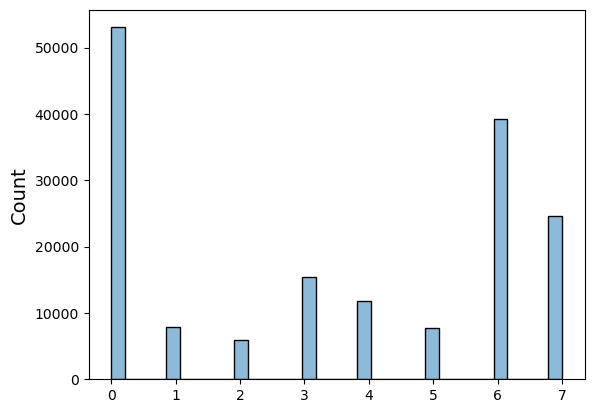

In [55]:
import seaborn as sns
sns.histplot(train_dataset.labels, legend=False)

In [56]:
X_train, y_train = train_dataset.imgs, train_dataset.labels

In [57]:
X_train.shape

(165466, 28, 28)

In [58]:
y_train.shape

(165466, 1)

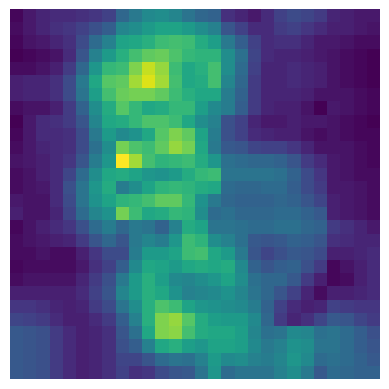

In [59]:
some_img = X_train[1,...]

plt.imshow(some_img)
plt.axis("off")
plt.show()

In [60]:
y_train[1]

array([0], dtype=uint8)

Let's have a better view:

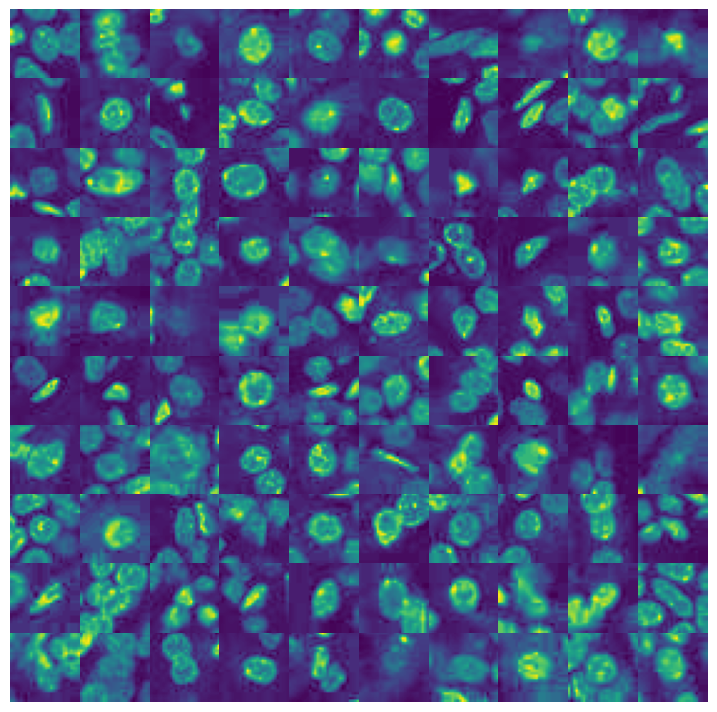

In [61]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plt.imshow(image_data)
    plt.axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

### Train & test dataset

We should always create a test set and set it aside before inspecting the data
closely. 

The MedMNIST dataset is actually already split into a training set, a validation set, and a test set. 
The training set is already shuffled for us, which is good as this guarantees that all
cross-validation folds will be similar.
Moreover, some learning algorithms are sensitive to the order of the training instances, 
and they perform poorly if they get many similar instances in a row. 
Shuffling the dataset ensures that this won’t happen

Let's prepare the test data:

In [62]:
X_test, y_test = test_dataset.imgs, test_dataset.labels

## Training a Binary Classifier

As an example of a binary classifier, we will try to identify one class: the number 5 (*smooth muscle*).
So, we distinguish between just two classes, 5 and not-5. 

In [63]:
# To speed up the processing time, we are going to convert the images to grayscale 
from skimage.color import rgb2gray

# Assuming X_train is an array of RGB images with shape (num_images, height, width, 3)
X_train = np.array([rgb2gray(img) for img in X_train])
X_test = np.array([rgb2gray(img) for img in X_test])

# Check shape of the grayscale images (num_images, height, width)
print(X_train.shape)
print(X_test.shape)


ValueError: the input array must have size 3 along `channel_axis`, got (28, 28)

In [20]:
# Let’s create the target vectors for this classification task
y_train_binary = (y_train == 0)  # True for all 5s, False for all other digits
y_test_binary = (y_test == 0)

In [21]:
y_train_binary
# Check the unique classes and their counts
print(np.unique(y_train_binary, return_counts=True))

(array([False,  True]), array([157761,   7705], dtype=int64))


In [22]:
# To work with SGD we have to reshape the data to 2D: (n_samples, n_features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [23]:
# Let's update the example image
some_img = X_train[1,...].flatten()

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train_binary.shape}")

X_train shape: (165466, 784)
y_train shape: (165466, 1)


In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_binary)

SGDClassifier(random_state=42)

In [27]:
sgd_clf.predict([some_img.flatten()])

array([False])

### Gradient Descent

Gradient Descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In machine learning, we use it to minimize the cost function of our models.

**Stochastic Gradient Descent** (SGD) is a variation of Gradient Descent. Instead of using the entire dataset to compute the gradient at each step, SGD uses a single randomly selected sample. This makes it faster and able to handle large datasets, but the path to the minimum is noisier.

The algorithm initializes the parameters ($\theta$) randomly and then improves them gradually.
At each step it attempts to decrease the cost function (e.g., the MSE), calculates the gradient of the loss function with respect to $\theta$, and updates $\theta$ by taking a small step in the direction of the negative gradient until the algorithm converges to a minimum.




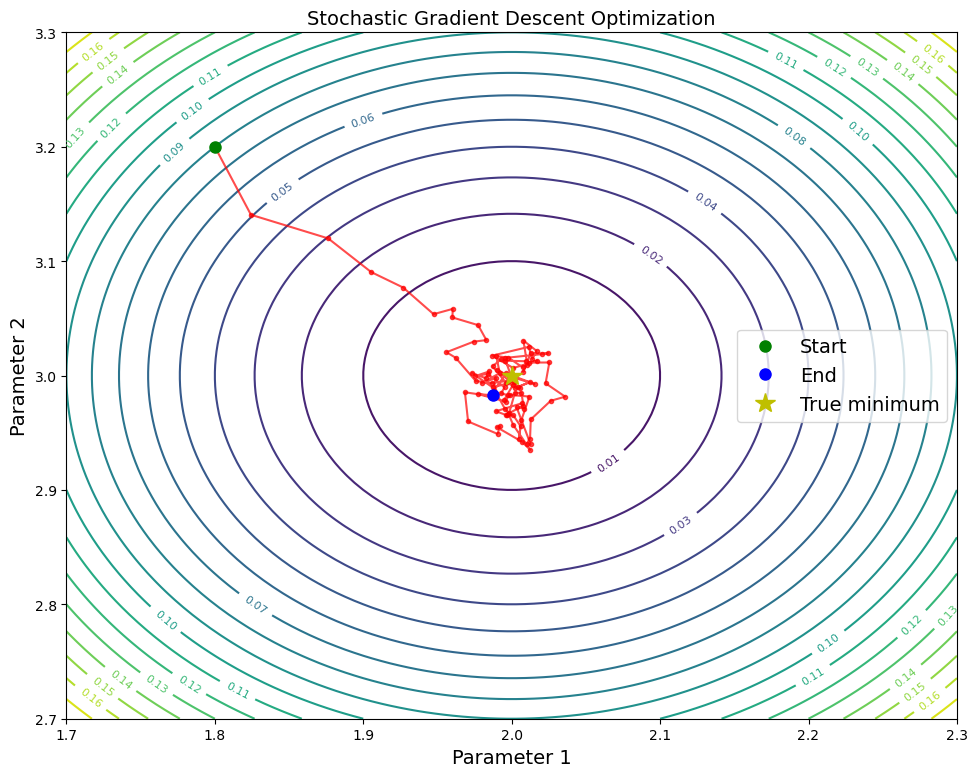

Final position: (1.9872, 2.9828)
Distance from true minimum: 0.0215


In [28]:
def cost_function(x, y):
    return (x - 2)**2 + (y - 3)**2

def gradient(x, y):
    return np.array([2*(x - 2), 2*(y - 3)])

def sgd(learning_rate, n_iterations, initial_x, initial_y):
    x, y = initial_x, initial_y
    path = [(x, y)]
    
    for _ in range(n_iterations):
        grad = gradient(x, y)
        noise = np.random.normal(0, 0.1, 2)  # Reduced noise for clearer visualization
        x -= learning_rate * (grad[0] + noise[0])
        y -= learning_rate * (grad[1] + noise[1])
        path.append((x, y))
    
    return np.array(path)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a grid of points (zoomed in)
x = np.linspace(1.7, 2.3, 100)
y = np.linspace(2.7, 3.3, 100)
X, Y = np.meshgrid(x, y)

# Calculate Z values for contour plot
Z = cost_function(X, Y)

# Plot contours
contours = ax.contour(X, Y, Z, levels=20, cmap='viridis')
ax.clabel(contours, inline=True, fontsize=8)

# Run SGD
path = sgd(learning_rate=0.1, n_iterations=100, initial_x=1.8, initial_y=3.2)

# Plot the SGD path
ax.plot(path[:, 0], path[:, 1], 'ro-', linewidth=1.5, markersize=3, alpha=0.7)
ax.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', markersize=8, label='End')

# Plot the true minimum
ax.plot(2, 3, 'y*', markersize=15, label='True minimum')

ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('Stochastic Gradient Descent Optimization')
ax.legend()

# Set axis limits for zoomed-in view
ax.set_xlim(1.7, 2.3)
ax.set_ylim(2.7, 3.3)

plt.tight_layout()
plt.show()

# Print final position
print(f"Final position: ({path[-1, 0]:.4f}, {path[-1, 1]:.4f})")
print(f"Distance from true minimum: {np.linalg.norm(path[-1] - np.array([2, 3])):.4f}")

To implement Gradient Descent, you need to compute the gradient of the cost function
with regards to each model parameter $\theta_j$. 

$$ \frac{\partial}{\partial \mathbf{\theta_j}} \mathrm{MSE}(\theta) = \frac{2}{m} \Sigma_{t=1}^m (\mathbf{\theta}^T \mathbf{x}^{(t)} - y^{(t)}) x_j^{(t)} $$ 

The gradient vector contains all the partial derivatives of the cost function (one for each model parameter)

$$
\nabla_\theta \mathrm{MSE}(\mathbf{\theta})  =  \frac{2}{m} \mathbf{X}^T (\mathbf{X}\mathbf{\theta} - \mathbf{y})
$$

#### Gradient descent step

$$
\mathbf{\theta}^{(step+1)} = \mathbf{\theta}^{(step)} - \eta \nabla_\mathbf{\theta} \mathrm{MSE}(\mathbf{\theta}^{(step)})
$$

where the hyperparameter $\eta$ is called the **learning rate**.

The **learning rate** hyperparameter represents the size of the steps. 
This is important because if the learning rate is too small, then the algorithm
will have to go through many iterations to converge, which will take a long time.

On the other hand, if the learning rate is too high, you might jump across the valley
and end up on the other side, possibly even higher up than you were before. This
might make the algorithm diverge.


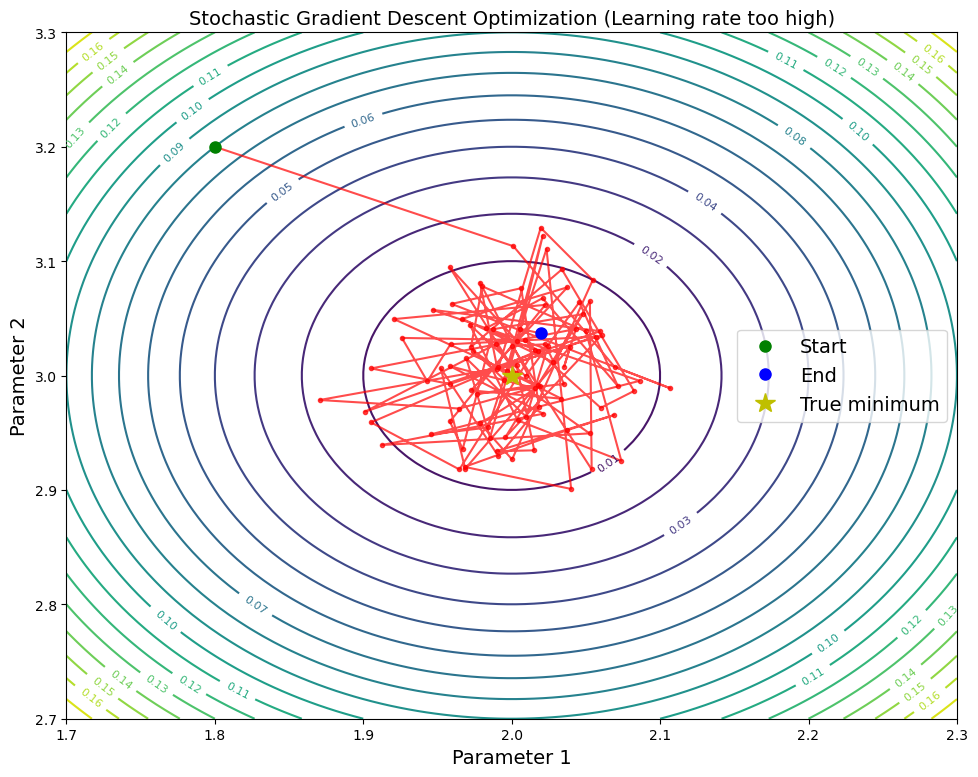

Final position: (2.0195, 3.0369)
Distance from true minimum: 0.0417


In [29]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a grid of points (zoomed in)
x = np.linspace(1.7, 2.3, 100)
y = np.linspace(2.7, 3.3, 100)
X, Y = np.meshgrid(x, y)

# Calculate Z values for contour plot
Z = cost_function(X, Y)

# Plot contours
contours = ax.contour(X, Y, Z, levels=20, cmap='viridis')
ax.clabel(contours, inline=True, fontsize=8)

# Run SGD
path = sgd(learning_rate=0.5, n_iterations=100, initial_x=1.8, initial_y=3.2)

# Plot the SGD path
ax.plot(path[:, 0], path[:, 1], 'ro-', linewidth=1.5, markersize=3, alpha=0.7)
ax.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', markersize=8, label='End')

# Plot the true minimum
ax.plot(2, 3, 'y*', markersize=15, label='True minimum')

ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('Stochastic Gradient Descent Optimization (Learning rate too high)')
ax.legend()

# Set axis limits for zoomed-in view
ax.set_xlim(1.7, 2.3)
ax.set_ylim(2.7, 3.3)

plt.tight_layout()
plt.show()

# Print final position
print(f"Final position: ({path[-1, 0]:.4f}, {path[-1, 1]:.4f})")
print(f"Distance from true minimum: {np.linalg.norm(path[-1] - np.array([2, 3])):.4f}")

#### GD regression example

In [30]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

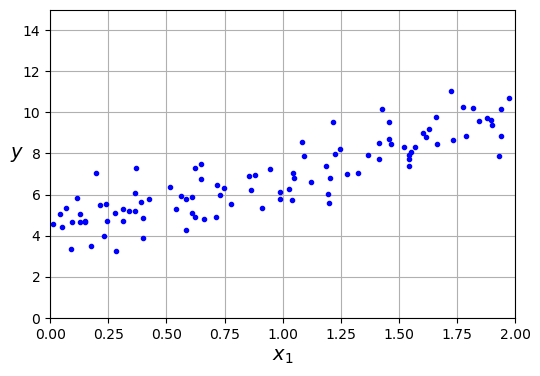

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [35]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
# theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance


In [36]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

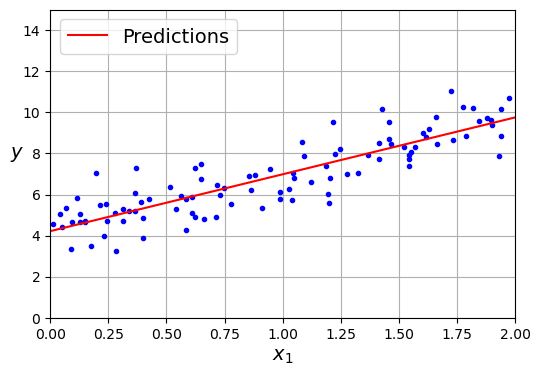

In [37]:
plt.figure(figsize=(6, 4)) 
plt.plot(X, y, "b.")
y_predict = X_new_b @ theta
plt.plot(X_new, y_predict, "r-", label="Predictions")


plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
plt.show()

The trained model parameters:

In [38]:
theta

array([[4.21509616],
       [2.77011339]])

#### Gradient Descent with various learning rate

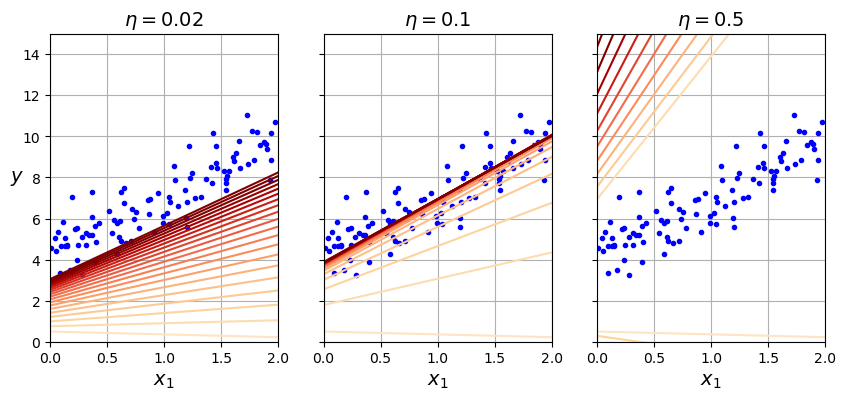

In [40]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)

plt.show()

#### Stochastic Gradient Descent

The main problem with (Batch) Gradient Descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. 

Instead, **Stochastic Gradient Descent** just picks a random instance in the training set at every step and computes the gradients based only on that single instance. 

Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration

Randomness is *good* to escape from local optima, but *bad* because it means
that the algorithm can never settle at the minimum. 

One solution is to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing the
algorithm to settle at the global minimum. 
The function that determines the learning rate at each iteration is called the **learning schedule**. 

If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a
long time and end up with a suboptimal solution if you halt training too early.


In [41]:
theta_path_sgd = [] 

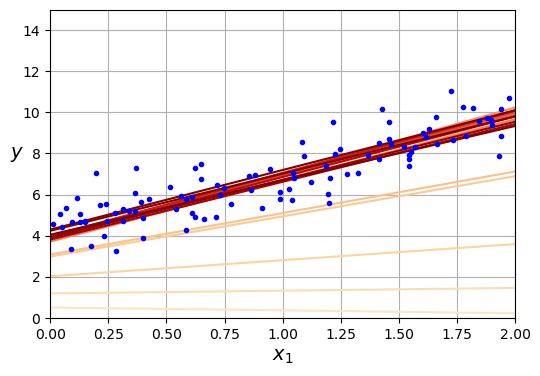

In [43]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # just needed to generate the figure below
plt.figure(figsize=(6, 4))  # not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code to generate the figure

# extra code – this section beautifies and saves the figure
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

plt.show()

While the Batch Gradient Descent code iterated 1,000 times through the whole training
set, this code goes through the training set only 50 times and reaches a fairly good
solution.

In [44]:
theta

array([[4.21076011],
       [2.74856079]])

Note that since instances are picked randomly, some instances may be picked several
times per epoch while others may not be picked at all.

>When using Stochastic Gradient Descent, the training instances must be **independent and identically distributed** (IID), to ensure that the parameters get pulled towards the global optimum, on average. A simple way to ensure this is to shuffle the instances during training.

To perform Linear Regression using SGD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. 

The following code runs for maximum 1000 epochs (max_iter=1000) or until the loss drops
#by less than 1e-3 during one epoch (tol=1e-3), starting with a learning rate of 0.1
#(eta0=0.1), using the default learning schedule ($\eta \propto 1/t $).

In [45]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [46]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

### Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate the `SGDClassifier` model using K-fold cross-validation, with 3 folds. 

K-fold crossvalidation means splitting the training set into K-folds (in this case, 3), then making
predictions and evaluating them on each fold using a model trained on the remaining folds

>Cross-validation allows to get not only an estimate of the performance of the model, 
>but also a measure of how precise this estimate is (i.e., its standard deviation). 
>But it comes at the cost of training the model several times, so it is not always possible.

In [47]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_binary, cv=3, scoring="accuracy")

array([0.95342302, 0.9534403 , 0.9534403 ])

The *accuracy* (ratio of correct predictions) is relatively high on all cross-validation folds.

However, let's compare it with the performance of a dummy classifier which always infers the most frequent class label in the observed `y` argument passed to `fit`. 

In [48]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_binary)
print(any(dummy_clf.predict(X_train)))

False


In [49]:
cross_val_score(dummy_clf, X_train, y_train_binary, cv=3, scoring="accuracy")

array([0.95342302, 0.9534403 , 0.9534403 ])

This is because only about 14% of the images are of class 5, so if you always guess that an image is not a 5, you will be right about 86% of the time.

>This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others).

<Axes: ylabel='Count'>

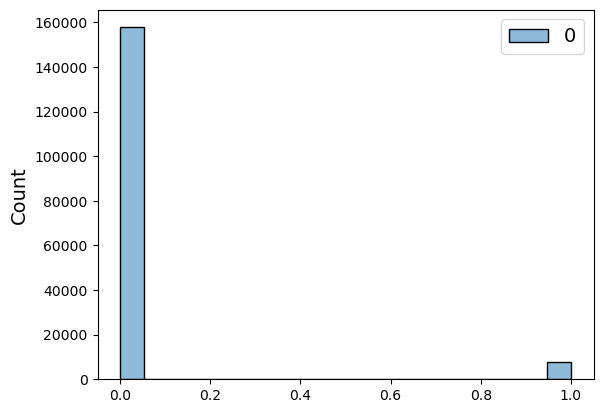

In [50]:
sns.histplot(y_train_binary)

### Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B.

To compute the **confusion matrix**, you first need to have a set of predictions, so they can be compared to the actual targets.

Just like the `cross_val_score()` function, c`ross_val_predict()` performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (*clean* meaning that the prediction is made by a model that never saw the data during training)

In [42]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_binary, cv=3)

Let's get the confusion matrix using the` confusion_matrix()` function.

Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_binary, y_train_pred)
cm

array([[77814,     0],
       [12182,     0]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

> A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal

## Precision and Recall

The confusion matrix gives a lot of information, but sometimes we may prefer a more concise metric. 

An interesting one to look at is the accuracy of the positive predictions; this is called the **precision** of the classifier:

$$ \mathrm{precision} = \frac{TP}{TP + FP} $$

TP is the number of true positives, and FP is the number of false positives.

In [44]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_binary, y_train_pred) 

0.0

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named **recall**, also called *sensitivity* or *true positive rate* (TPR).

This is the ratio of positive instances that are correctly detected by the classifier:

$$
\mathrm{recall} = \frac{TP}{TP + FN} 
$$

In [45]:
recall_score(y_train_binary, y_train_pred)  

0.0

Now the 5-detector does not look as good as it did when we looked at its accuracy.

#### The $F_1$ score

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The $F_1$ score is
the harmonic mean of precision and recall:

$$
F_1 = \frac{2}{\frac{1}{\mathrm{precision}} + \frac{1}{\mathrm{recall}}}
$$

In [46]:
from sklearn.metrics import f1_score

f1_score(y_train_binary, y_train_pred)

0.0

The $F_1$ score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall. 

Unfortunately, we can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff.

### Precision/Recall Trade-off

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification
decisions. For each instance, it computes a score based on a **decision function**,
and if that score is greater than a *threshold*, it assigns the instance to the positive
class, or else it assigns it to the negative class.

`Scikit-Learn` does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.

In [47]:
y_scores = sgd_clf.decision_function([some_img.flatten()])
y_scores

array([-1.01090643])

In [48]:
threshold = 0
y_some_image_pred = (y_scores > threshold)

The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same
result as the `predict()` method.

In [49]:
y_some_image_pred

array([False])

We can see that if we change the threshold, the recall changes

In [50]:
threshold = -3000
y_some_image_pred = (y_scores > threshold)
y_some_image_pred

array([ True])

How do we decide which threshold to use? 

Let's get the scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of predictions.

In [52]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_binary, cv=3,
                             method="decision_function")

ValueError: Only 2 class/es in training fold, but 1 in overall dataset. This is not supported for decision_function with imbalanced folds. To fix this, use a cross-validation technique resulting in properly stratified folds

In [53]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=3)

# Placeholder to store predictions
y_scores = np.zeros(len(X_train))

# Manually run cross-validation
for train_index, test_index in stratified_kfold.split(X_train, y_train_binary):
    # Train model on the training set
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_binary[train_index]
    X_test_fold = X_train[test_index]
    
    # Fit the model on this fold
    sgd_clf.fit(X_train_fold, y_train_fold)
    
    # Get decision function scores for the test fold
    y_scores[test_index] = sgd_clf.decision_function(X_test_fold)

# `y_scores` now holds the predictions for each instance


Then, with these scores we can compute precision and recall for all possible thresholds
using the `precision_recall_curve()` function:

In [54]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_binary, y_scores)

Finally, we can plot precision and recall as functions of the threshold value.

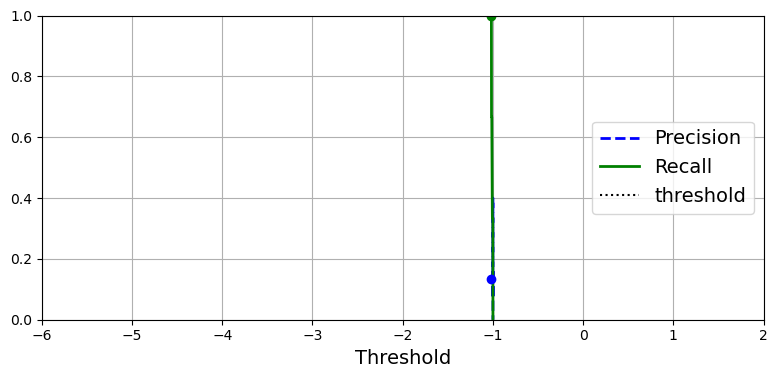

In [55]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-6, 2, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly
against recall.

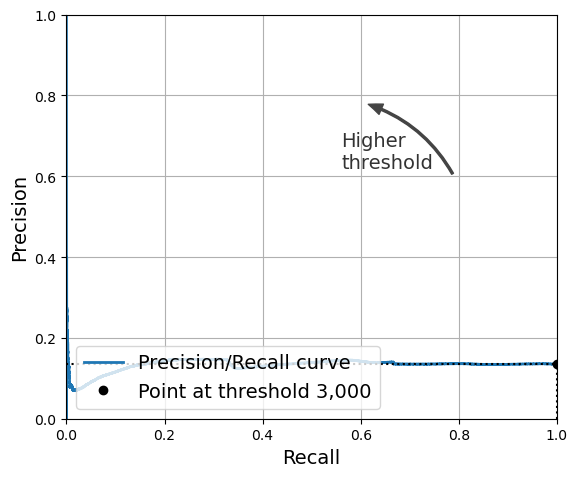

In [56]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

Precision really starts to fall sharply around 80% recall. 

We will probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. 

But of course the choice depends on the project.


Let’s suppose you decide to aim for 90% precision. 

Looking up the first plot, we find that we need to use a threshold of about 8,000. 

To be more precise we can search for the lowest threshold that gives us at least 90% precision.

In [57]:
idx_for_90_precision = (precisions >= 0.25).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

-0.9999271109557081

In [58]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [59]:
precision_score(y_train_binary, y_train_pred_90)

0.25

>A high-precision classifier is not very useful if its recall is too low

In [60]:
recall_at_90_precision = recall_score(y_train_binary, y_train_pred_90)
recall_at_90_precision

0.0009850599244787392

### The ROC Curve

The **receiver operating characteristic** (ROC) curve is another common tool used with
binary classifiers. 

The ROC curve plots the **true positive rate** (TPR), i.e., *recall*, against the **false positive rate** (FPR), which is one minus the **true negative rate**.

In [61]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_binary, y_scores)

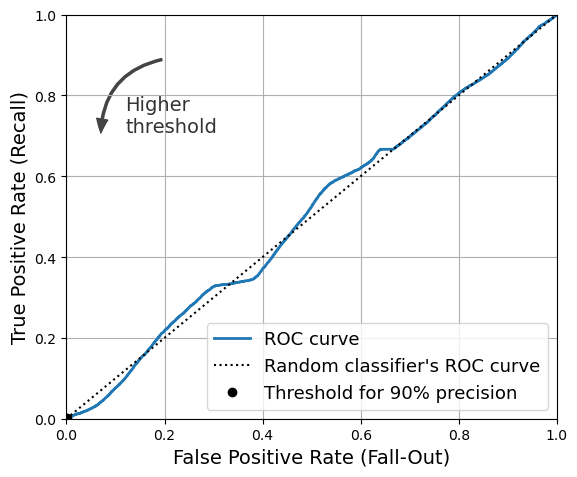

In [62]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

The dotted line represents the ROC curve of a purely random classifier.

>A good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve** (AUC). 

>A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [63]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_binary, y_scores)

0.502994526554503

This way we can compare different methods.



## Multiclass Classification

Some algorithms (such as **Random Forest** classifiers) are capable of handling multiple classes directly. 
Others (such as **Support Vector Machine** classifiers or **Linear** classifiers) are strictly binary classifiers. 

However, there are various strategies that we can use to perform multiclass classification using multiple
binary classifiers.

#### One-versus-all (OvA) strategy

To classify the digit images into 10 classes (from 0 to 9), the  **one-versus-all** (OvA) strategy consists in training 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

#### One-versus-one (OvO) strategy

Another strategy is to train a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.

If there are N classes, we need to train $ N \times (N – 1) / 2$ classifiers. 

For the MNIST problem, this means training 45 binary classifiers! 

When we want to classify an image, we have to run the image 
through all 45 classifiers and see which class wins the most duels. The main advantage
of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Some algorithms (such as **Support Vector Machine** classifiers) scale poorly with the
size of the training set, so for these algorithms **OvO** is preferred since it is faster to
train many classifiers on small training sets than training few classifiers on large
training sets. For most binary classification algorithms, however, **OvA** is preferred.

`Scikit-Learn` detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm.

>**Warning**: the following cell may take a few minutes to run:

In [64]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)


SGDClassifier(random_state=42)

In [65]:
sgd_clf.predict([some_img.flatten()])

array([6], dtype=uint8)

In [66]:
sgd_clf.decision_function([some_img.flatten()]).round()

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1.]])

**Warning:** the following two cells may take a few minutes each to run:

In [67]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.21100703, 0.17393913, 0.28495233])

Simply scaling the inputs increases accuracy

In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

# Error Analysis

Once we have found a promising model, we want to find ways to improve it. 

One way to do this is to analyze the types of errors it makes.

**Warning:** the following cell will take a few minutes to run:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal,
which means that they were classified correctly.

Let's divide each value in the confusion matrix by the number of images in the corresponding class to compare error rates.

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now, to clearly see the kinds of errors the classifier makes, let's fill the diagonal with zeros.

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

A few observations:

- The column for class 8 is quite bright, which tells that many images get misclassified as 8s. 

- However, the row for class 8 is not that bad, so that actual 8s in general get properly
classified as 8s. 

- The confusion matrix is not necessarily symmetrical. 

- 3s and 5s often get confused (in both directions).

Looking at this plot, it seems that our efforts should be spent on reducing the false 8s. 

- For example, we could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s.
- Alternatively, we could engineer new features that would help the classifier—for example, writing
an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has
none). 
- Or we could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to gain insights on what our
classifier is doing and why it is failing, but it is more difficult and time-consuming.

Let’s plot examples of 3s and 5s. 

In [60]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them

However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did.

The reason is that we used a simple `SGDClassifier`, which is a linear model. 
All it does is assign a weight per class to each pixel, and when it sees a new image it just
sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s
differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the
top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left,
the classifier might classify it as a 5, and vice versa. In other words, this classifier is
quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion
would be to preprocess the images to ensure that they are well centered and not too
rotated. This will probably help reduce other errors as well.

## Multilabel Classification

In some cases we may want our classifier to output multiple classes for each instance.

For example, if we have trained a classifier to recognize three faces, for each picture we would like it to output multiple binary tags. This is called a **multilabel classification system**.

Let’s look at a simpler example, a classifier that tell us if a digit is large ($\ge 7$) and/or odd.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_img])

This code computes the average F1 score across all labels:



In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification

The last type of classification task we are going to discuss here is called *multioutput-multiclass
classification* (or simply **multioutput classification**). 

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).


To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, represented
as an array of pixel intensities, just like the MNIST images.

>Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

Let’s start by creating the training and test sets by taking the MNIST images and
adding noise to their pixel intensities using NumPy’s `randint()` function.


In [65]:

np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

Now let’s train the classifier and make it clean this image.

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")
plt.show()